# Support Vector Machine

> “Nothing is more practical than a good theory.”
> -Kurt Lewin, Vladimir Vapnik



클로드 섀넌 등 위대한 석학들이 거쳐간 벨 연구소에서 (그 당시의) 머신러닝 분류기법의 4번타자인 Support Vector Machine 이 1995년 블라디미르 바프닉의 연구 끝에 탄생했다.

Computational Complexity 에 대한 한계가 명확한 신경망을 제치고 SVM 은 효과적인 모델로 자리잡았다. 고차원에서 좋은 성능을 보이고, 샘플 수 보다 차원 수가 높아도 준수한 성늘을 보이고, 본질적으로 Computational Complexity 가 낮은 SVM 에 대한 연구는 계속되었다.

하지만 SVM 을 완성시킨 바프닉이 말한 것 처럼 2000년대 이후 SVM은 신경망을 뛰어넘지 못했고, 딥러닝이 대세가 된 현재 SVM 의 practical application 은 찾기 힘들다.

그렇다고 SVM 을 고대의 유물취급하기엔 kernel trick 등 효과적인 이론들을 머신러닝에 도입시켰고, ‘근본’ 모델 중 하나이기에 배울 수 있는게 많다. 바프닉의 말처럼 **좋은 이론만큼 실용적인 것은 없기 때문이다.**



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import cvxopt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
sns.set()

## Margin

기존 딥러닝을 괴롭히는 고질병같은 overfitting 은 training data 의 성능이 과도하게 좋으면 일어난다. 이런 overfiited model 은 미래 데이터에 대한 예측이 떨어지기에, generalization 을 챙겨야한다.

Overfitting 과 generalization ability 간의 tradeoff 에 대한 연구는 신경망쪽에서 활발하지만, SVM은 본질적으로 statistical learning theory 에 기반해 있기 때문에 train error 이 줄어들면 test error 도 줄어드는 모델이다.

![Hyperplane](../images/hyperplane.png)

2개의 class 를 완벽히 분류하는 hyperplane 은 $w^T + b = 0$ 이며,  $w$는 hyperplane 의 법선벡터, $b$는 bias 다. $w$는 우리가 흔히 알고 있는 hyperplane 의 기울기, $b$는 hyperplane 의 y-intercept 라고 생각하면 간단하다. 

본질적으로 $N$차원의 data point 들을 정확히 분류하는 hyperplane 을 찾는 것을 **SVM 을 학습시킨다** 라고 한다. 그렇기 때문에 $w, b$를 찾는 것이 궁극적인 목표다. 하지만 feature space 위의 데이터포인트들을 보면 두개의 클라스를 분류하는 hyperplane 은 여러개 일 수 있다.

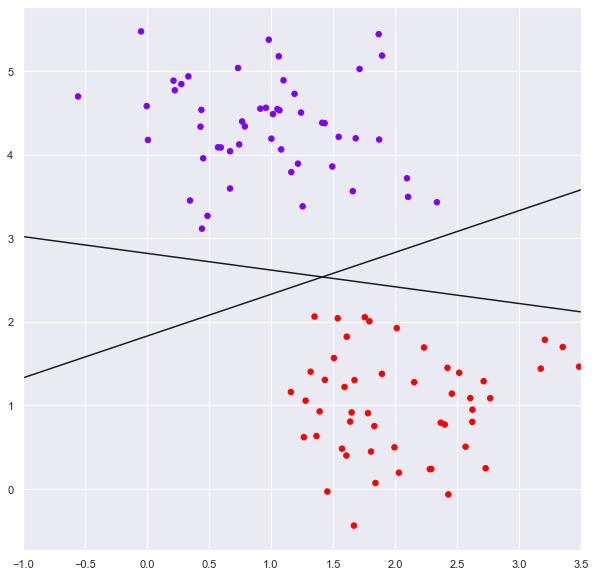

In [9]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.60)
xfit = np.linspace(-1, 3.5)
c1 = (0.5, 1.83, 0.43)
c2 = (-0.2, 2.82, 0.37)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='rainbow');
for w, b, d in [c1, c2]:
    yfit = w * xfit + b
    plt.plot(xfit, yfit, '-k')
plt.xlim(-1, 3.5);

위 예시를 보면, 두개의 클래스로 이루어진 데이터포인트들을 잘 분류하는 경계면이 두개가 있다. 인공신경망을 통해 해당 경계면을 학습했다면, **두 경계면 중 어떤 분류기가 옳은 분류기라는 답을 낼 수 없다.** 인공신경망, SVM 그리고 그 어떤 머신러닝 모델은 training data 를 완벽히 분류할 수 있는 hyperplane 이 많이 존재하더라도 미래에 들어올 데이터도 잘 분류하는 최적의 hyperplane 을 찾아야 한다.

그리고 SVM 에서는 margin 이라는 개념을 도입해서 **최적의 hyperplane 단 하나를 찾는다.**

![Margin](../images/margin.png)

위 그림을 보면 두개의 클래스를 잘 구분하는 hyperplane 이 있다. 각 클래스에서 Hyperplane 과 가장 가까운 점들이 있고, 해당 점들은 또 다른 점선에 놓여있다. 해당 점선들을 각각 plus plane, minus plane 이라 부르며 이 두 plane 의 거리를 margin 이라 한다. Margin 이 클수록 두 클래스는 더 멀리 떨어져 있다는 것을 의미하며, 해당 training set 에서 margin 이 제일 큰 hyperplane 을 찾으면 미래 데이터도 잘 구분할 수 있다는 것을 의미한다.

**SVM의 목적은 이 margin 을 최대화 하는 hyperplane 을 찾는 것이다**. hyperplane 의 $w$ 가 법선벡터임을 여기서 알 수 있다.

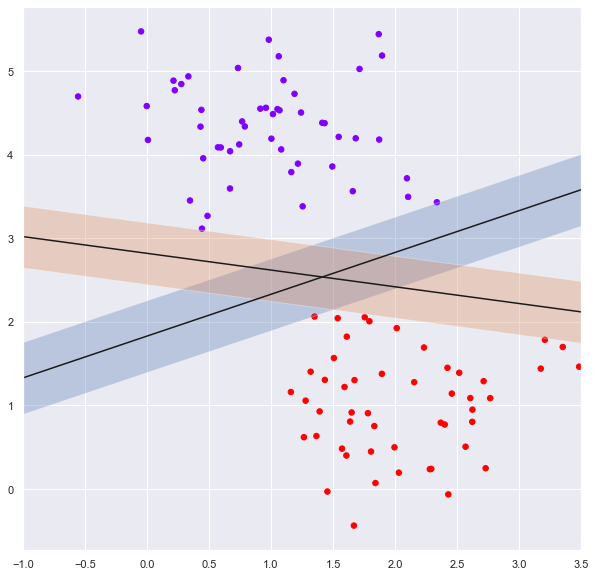

In [10]:
xfit = np.linspace(-1, 3.5)
c1 = (0.5, 1.83, 0.43)
c2 = (-0.2, 2.82, 0.37)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='rainbow');
for w, b, d in [c1, c2]:
    yfit = w * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, alpha=0.3)

plt.xlim(-1, 3.5);

앞선 예시로 돌아가, 두개의 hyperplane 이 있다. SVM 을 통해 최적해의 hyperplane 을 구한다면, margin 이 더 큰 파란색의 hyperplane 이 최적해 일 것이다.

## Problem Formulation

SVM의 목적은 margin 을 최대화하는 hyperplane 을 찾는 것이다. 이를 수식으로 표현하는 과정은 복잡해 보이지만, 생각보다 간단하다. Plus plane 위의 점을 $x^+$, minus plane 위의 점을 $x^-$ 라고 부르겠다. 이때 $w$는 hyperplane 과 법선벡터이기 때문에 $x^+$과 $x^-$ 를 평행이동관계로 표현 할 수 있다.

$$
x^+ = x^- + \lambda w
$$

위 식은 최적화에서의 Basic Search Scheme 과 동일한 개념이다. $x^-$를 $w$ 방향으로 $\lambda$ 만큼 이동시키면 $x^+$ 가 된다는 것을 의미한다.

Margin 을 최대화하는 hyperplane 을 찾으려 한다. 그렇다면 margin 을 계산 가능한 식으로 유도해야 하는데, 위 평행이동관계식으로 margin 을 $w$로 표현 할 수가 있다. 먼저 $\lambda$를 $w$로만 표현하면 다음과 같다.

$$
x^+ = x^- + \lambda w\\\\
w^Tx^+ + b = 1\\
w^T(x^-+\lambda w)+b=1\\
w^Tx^-+b+\lambda w^Tw = 1\\
-1 + \lambda w^Tw = 1\\\\
\lambda = \frac 2 {w^Tw}
$$

그 다음 Margin 자체를 유도해야 한다. Margin 은 $x^+, x^-$ 사이의 거리이기 때문에 L2 norm 으로 전개를 할 수 있다.

$$
margin = ||x^+ - x^-||_2\\
=||x^- + \lambda w - x^-||_2\\
=||\lambda w||_2\\
=\lambda \sqrt{w^Tw}\\
$$

Margin 을 전개한 식 $\lambda \sqrt{w^Tw}$ 에 평행이동관계식에서 도출한 $\lambda = \frac 2 {w^Tw}$을 대입하면 다음과 같다.

$$
margin = \frac 2 {w^Tw} \sqrt{w^Tw}\\
= \frac 2 {\sqrt {w^Tw}}\\
= \frac 2 {||w||_2}
$$

SVM의 목적은 $\frac 2 {||w||_2}$ 를 최대화 하는걸로 귀결된다. 이 최대화 문제에 역수를 취해 최소화 문제로 만들면 다음과 같다.
$$
min \  \frac 1 2 \mid\mid w \mid\mid ^2_2
$$
기존 문제에 역수를 취해 $min$ 문제로 만든 뒤 L2 norm 의 제곱근을 없애기 위해 목적식에 제곱을 취해주면 **$w$ 로 표현한 SVM 의 목적식을 얻을 수 있다.**

$$
min \  \frac 1 2 \mid\mid w \mid\mid ^2_2 \rightarrow Objective \ function

$$

![Margin](../images/margin.png)

목적식을 구했다면 제약식을 구할 차례다. SVM 에 새로운 데이터 포인트가 들어온다고 생각해보자. 그렇다면 해당 데이터포인트는 $+1, -1$ 둘 중 하나의 클라스로 구분 될 것이고, $+1$이라면 plus plane 보다 위에 있을 것이고 $-1$이라면 minus plane 보다 아래에 있을 것이다. 데이터포인트의 클라스 (혹은 정답 레이블) 는 $y_i$ 로 표현을 한다면, 위 제약식을 수식으로 쓰면 다음과 같다.

> $y_i(w^Tx_i+b)\geq 1, i=1,2,...n \rightarrow Constraints$ 

이렇게 SVM 의 목적식과 제약식을 구할 수 있다.

#### Original Problem

> $\min \  \frac 1 2 \mid\mid w \mid\mid ^2_2 \rightarrow Objective \ function$
>
> $s.t \ y_i(w^Tx_i+b)\geq 1, i=1,2,...n \rightarrow Constraints$ 

목적식의 변수 $w$ 에 제곱이 붙어있고, 제약식은 linear 하다. 이렇게 SVM을 최적화에서 그토록 많이 배운 2차계획법 (Quadratic Programming, QP) 문제로 유도한 것이다. 이런 minimizing QP 문제는 convex optimization 이기 때문에, 전역최적해 (Global Minimum) 이 존재한다. 즉, **목적식을 최소화하는 $w,b$ 가 단 하나만 존재한다는 뜻이다.**

## 

## Lagrangian Multiplier Method and KKT Condition

SVM 의 Original Problem 은 QP 문제다. QP 문제는 전역최적해가 하나여서 다른 heuristics 가 필요 없다는 점에서는 좋지만, 제약식이 있는 최적화 문제는 추가 단계를 거처야만 풀 수 있다. 제약식이 연립방정식이면 라그랑주 승수법을 통해 새로운 최적화 문제를 풀어야 하고, 제약식이 연립부등식이면 KKT 조건이란 것을 만족하도록 유도해야 한다. SVM 의 Original Problem 을 유도하다 보면 라그랑주 승수법과 KKT 조건을 둘다 사용한다.




### Lagrangian Multiplier Method

라그랑주 승수법이란 라그랑주 승수 (Lagrange Multiplier, 보조함수) 를 통해 제약 조건이 있는 최적화 문제를 풀기 위한 방법이다. SVM 의 경우엔 라그랑주 승수법은 제약식을 없애는 역할로 사용된다.

> 보통 라그랑주 승수는 $\lambda$ 로 표현하는 경우가 많지만, 대부분의 소스와 예제에선 $\alpha$ 를 사용한다.

기존 Original Problem 을 라그랑주 승수법을 통해 Lagrangian Primal 문제로 변환시키면 다음과 같다.

**Original Problem**

> $\min \  \frac 1 2 \mid\mid w \mid\mid^2_2 \rightarrow Objective \ function$
>
> $s.t \ y_i(w^Tx_i+b)\geq 1, i=1,2,...n \rightarrow Constraints$ 

**Lagrangian Primal**

> $\max_\alpha\min_{w,b} \mathcal{L}(w,b,a) = \frac 1 2 \mid\mid w \mid\mid ^2_2 - \sum \alpha_i(y_i(w^Tx_i+b)-1) \rightarrow Objective \ function$
>
> $s.t \ \alpha_i \geq 0 \ , \ i=1,2,...,n \rightarrow Constraints$

Original Problem 의 목적식과 제약식이 Lagrangian Primal 에선 $\alpha$ 를 통해 하나의 목적식으로 합쳐졌고, 기존 제약식의 범위가 1보다 커야 했기 때문에 $\alpha$ 가 0보다 커야 한다는 제약식이 생긴다. 이 Lagrangian Primal 문제의 목적식이 $\max\min$ 이기 때문에, $\max$ 만 존재하는 쌍대문제 (Dual) 로 바꿔 풀어야 한다. 즉, **Primal formulation 을 minmize 후 Dual formulation 을 maximize 하면 된다.** 

Primal formulation 또한 Original Problem 과 같이 QP 이기 때문에 Convex 하고 Continuous 하다. 0에서 최솟값을 갖기 때문에 $w, b$ 에 대해서 편미분을 해야한다.
$$
\frac {\partial \mathcal{L}(w,b,\alpha_i)}{\partial w}=0 \rightarrow w = \sum^n_{i=1}\alpha_iy_ix_i\\
\frac {\partial \mathcal{L}(w,b,\alpha_i)}{\partial b}=0 \rightarrow \sum^n_{i=1}\alpha_iy_i=0
$$
이렇게 두가지 수식을 구할 수 있다. **되짚어보면 우리의 목적은 $w, b$ 를 구하는 것이다.** 첫번째 수식에 $w$ 에 대한 정의가 있는데, $\alpha$ 를 찾아야 하다. 그리고 두번째 수식에서 $\alpha$ 와 $y$ 의 곱의 합이 0이 되어야 한다는 것 또한 알게 되었다. 이 두가지 식을 다시 Primal formulation 에 대입을 하면 $\alpha$ 값을 최대화 시키는것이 목적인 dual 문제로 변환시킬 수 있다.



### Deriving Lagrangian Dual

Primal 을 Dual 로 바꾸는것은 어렵지 않다. 편미분을 통해 얻은 두 수식을 Primal 문제에 대입만 해주면 된다.

> $Primal: \min_{w,b} \mathcal{L}(w,b,a) = \frac 1 2 \mid\mid w \mid\mid ^2_2 - \sum \alpha_i(y_i(w^Tx_i+b)-1)$
>
> $ w = \sum^n_{i=1} \alpha_i y_i x_i$
>
> $\sum^n_{i=1} \alpha_i y_i=0$


> $Dual: \max_\alpha \sum^n_{i=1} \alpha_i - \frac 1 2 \sum^n_{i=1} \sum^n_{j=1} \alpha_i \alpha_j y_i y_j x^T_i x_j$
>
> $s.t \ \sum^n_{i=1}\alpha_i y_i = 0, \ \alpha_i \geq 0, \ i=1,2,...,n$

위 Dual 문제도 Original Problem, Primal formulation 과 동일한 QP다. 그렇기 때문에 목적식을 만족시키는 $\alpha$ 는 하나만 존재한다. $\alpha$ 를 구하면 $w = \sum^n_{i=1}\alpha_iy_ix_i\\$ 를 통해 $w$ 를 구할 수 있다. 하지만 위에서 언급한 것 처럼 QP 문제에서 제약식이 연립부등식이면 KKT 조건을 만족시켜야 한다.


### Karush-Kuhn-Tucker Conditions

일반적인 KKT 조건이라 하면 다음과 같은 3가지의 조건을 의미한다.

1. 모든 독립변수에 대한 미분값은 0이다 - Stationary 조건
2. 모든 라그랑주 승수와 제한조건 부등식의 곱은 0이다 - Primal Feasibility 조건
3. 라그랑주 승수는 음수가 아니어야 한다 - Dual Feasibiliity 조건

SVM 의 겨우엔, $w, b,a$ 가 Lagrangian dual 의 최적해가 되기 위해서 KKT 조건을 풀어쓰면 다음과 같이 수식화 할 수 있다.

1. Stationary

> $\frac {\partial \mathcal{L}(w,b,\alpha_i)}{\partial w}=0 \rightarrow w = \sum^n_{i=1}\alpha_iy_ix_i\\
> \frac {\partial \mathcal{L}(w,b,\alpha_i)}{\partial b}=0 \rightarrow \sum^n_{i=1}\alpha_iy_i=0$

2. Primal Feasibility

> $y_i(w^Tx_i+b)\geq 1, i=1,2,...n$

3. Dual Feasibility

> $\ \alpha_i \geq 0, \ i=1,2,...,n $

4. Complementary Slackness

> $\alpha_i(y_i(w^Tx_i+b)-1)=0$

그런데 자세히 보면 첫 3가지 조건들은 익숙하다. Stationary 조건은 Lagrangian Primal 의 독립변수들을 편미분할때 사용했다. Primal Feasibility 는 Original Problem 의 제약식이고, Dual Feasibility 는 Lagrangian Primal 의 제약식이다. 이미 첫 3가지 KKT 조건을 염두에 두고 Dual Problem 을 유도한 것이다. 그렇기에 마지막 조건인 Complementary Slackness 를 통해 우리는 최종해를 구할 수 있다.

## Final Solution 

KKT의 첫번째 조건을 유도하는 과정에서 $ w = \sum^n_{i=1}\alpha_iy_ix_i$ 를 통해 최종 해를 구할 수 있다는 것을 안다. $x_i, y_i$ 는 학습데이터이기 때문에 $\alpha_i$ 만 찾으면 된다. 이는 Complementary Slackness 를 통해 찾을 수 있다.
$$
\alpha_i(y_i(w^Tx_i+b)-1)=0
$$
Complementary Slackness 조건을 보면 $\alpha_i$ 와 $y_i(w^Tx_i+b)-1$ 중 **반드시 하나는 0의 값을 가져야 한다는 것을 알 수 있다.** 그렇다면 두가지 경우를 생각 할 수 있다.

1. $\alpha_i > 0 \ and \ y_i(w^Tx_i+b)=1$
2. $\alpha_i = 0 \ and \ y_i(w^Tx_i+b)-1\neq 0$

첫번째 경우의 두번째 항목을 자세히 보면 margin 의 수식인 것을 알 수 있다. 이는 training set 의 $x_i$ 가 plus plane 혹은 minus plane 위에 있다는 것을 의미하며, 해당 $x_i$ 를 **support vector** 이라 부른다.

두번째 경우는 $x_i$ 가 plus plane 혹은 minus plane 위에 있지 않다는 것을 의미한다. 그렇기 때문에 Hyperplane 을 구축하는데 있어서 영향을 미치지 않는다.

첫번째 경우에서 찾은 support vector 을 찾으면 margin 을 찾은 것과 다름없다. 왜냐하면 support vector들로 plus plane, minus plane 을 구할 수 있으며 최종적으로 두 Plane 간의 거리가 maximum margin 이기 때문이다.


## Code Implementation

In [13]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.60)
y[y == 0] = -1
y = y.astype(np.float64)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

n_samples, n_features = X.shape
kernel = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        kernel[i,j] = np.dot(X[i], X[j])
P = cvxopt.matrix(np.outer(y, y) * kernel)
q = cvxopt.matrix(np.ones(n_samples) * -1)
A = cvxopt.matrix(y, (1, n_samples))
b = cvxopt.matrix(0.0)
G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
h = cvxopt.matrix(np.zeros(n_samples))
solution = cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -1.0839e+01 -1.9235e+01  3e+02  2e+01  2e+00
 1: -1.4189e+01 -5.2787e+00  4e+01  2e+00  3e-01
 2: -1.8917e+00 -1.6322e+00  2e+00  1e-01  1e-02
 3: -1.4181e+00 -1.4347e+00  2e-01  1e-02  1e-03
 4: -1.4206e+00 -1.4210e+00  3e-03  2e-04  2e-05
 5: -1.4208e+00 -1.4208e+00  3e-05  2e-06  2e-07
 6: -1.4208e+00 -1.4208e+00  3e-07  2e-08  2e-09
Optimal solution found.


앞선 예시에 SVM 을 적용하기 위해 `cvxopt` 라는 컨벡스 최적화 [라이브러리](https://cvxopt.org/) 를 사용하였다. 데이터 자체는 `sklearn` 의 `make_blobs` 라는 메서드를 사용했기 때문에, 원래 데이터의 공간에서도 linearly seperable 하다. 그렇기에 penalty terms 나 커널 트릭을 사용하지 않는 Hard margin SVM 을 적용해도 위와 같이 전역최적해를 찾는 것을 볼 수 있다.

위 Cell 의 line 2 `y[y == 0] = -1` 를 보면 샘플들의 `class_label=0` 을 `-1` 로 바꿔주는 것을 볼 수 있다. 이는 SVM 의 Original problem 의 $y_i(w^Tx_i+b)\geq 1, i=1,2,...n$ 제약식을 하나로 표현하기 위해 진행하는 작업이다. 만약 class label 들이 0과 1 이라면 Original problem 에서의 제약식을 하나로 표현할 수 없게 된다.

In [14]:
a = np.ravel(solution['x'])
sv = a > 1e-5
ind = np.arange(len(a))[sv]
a_return = a[sv]
sv_return = X[sv]
sv_y_return = y[sv]
b_return = 0
for n in range(len(a_return)):
    b_return += sv_y_return[n]
    b_return -= np.sum(a_return * sv_y_return * kernel[ind[n], sv])
b_return /= len(a_return)
w_return = np.zeros(n_features)
for n in range(len(a_return)):
    w_return += a_return[n] * sv_y_return[n] * sv_return[n]

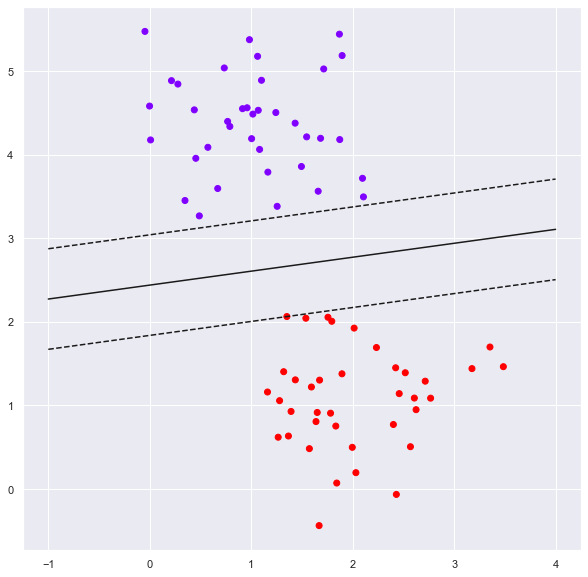

In [16]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]
plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rainbow')

# w.x + b = 0
a0 = -1; a1 = f(a0, w_return, b_return)
b0 = 4; b1 = f(b0, w_return, b_return)
plt.plot([a0,b0], [a1,b1], 'k')

# w.x + b = 1
a0 = -1; a1 = f(a0, w_return, b_return, 1)
b0 = 4; b1 = f(b0, w_return, b_return, 1)
plt.plot([a0,b0], [a1,b1], 'k--')
# w.x + b = -1
a0 = -1; a1 = f(a0, w_return, b_return, -1)
b0 = 4; b1 = f(b0, w_return, b_return, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

Plot 을 그려보면 train set 을 통해 margin 이 최대화 되는 hyperplane 을 찾은 것을 볼 수 있다.

In [17]:
y_pred = np.sign(np.dot(X_test, w_return) + b_return)
confusion_matrix(y_test, y_pred)

array([[13,  0],
       [ 0, 12]])

Margin 이 클수록 두 클래스는 더 멀리 떨어져 있다는 것을 의미하며, 해당 training set 에서 margin 이 제일 큰 hyperplane 을 찾으면 미래 데이터도 잘 구분할 수 있다는 것을 의미한다. 이를 확인하기 위해 test set 에 대한 예측을 해보니, Accuracy 가 100% 로 나오는 것을 볼 수 있다.